In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = os.path.abspath(".") 
if project_root not in sys.path:
    sys.path.append(project_root)
print(sys.path[-1])


from reward_func.evo_devo import coord_reward_func, oscillator_reward_func, somitogenesis_reward_func


/Users/dannyhuang/Developer/gflownet2/base


# test reward function 

In [2]:
import time

test_state = (50, -53, -57, 8, 9, -6, -117, 81, 8)

start_time = time.perf_counter_ns()
test_reward = coord_reward_func(test_state)
end_time = time.perf_counter_ns()
print(f"Time taken to run coord_reward_func: {(end_time - start_time)/1e9:.9f} seconds")

print(f"Test reward for state {test_state}: {test_reward}")
    



# test_weights = [-5, 2, 3, 1, 2, -1, 2, 1, -3] 
# test_weights = [0, -10, 0, 4, 6, -10, -10, 0, 0]  # w12=-5, w22=..., w23=-10, w31=-10 
# test_weights = [154, -200, 82, -33, 90, -90, -82, -13, 30] 
# reward = oscillator_reward_func(test_weights, plot=True)
# print(f"Reward for oscillator: {reward}")

Time taken to run coord_reward_func: 0.000041500 seconds
Test reward for state (50, -53, -57, 8, 9, -6, -117, 81, 8): 4


Total boundaries across 3 timepoints: 19
Stability reward: 0.972
Reward for somitogenesis: 17.448


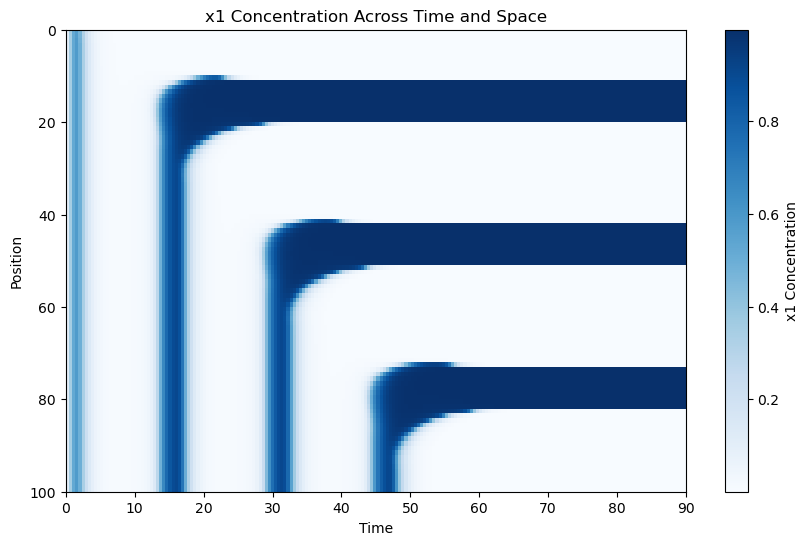

In [22]:


"""Slope"""
# test_weights =(77, 135, -100, 55, 200, -200, 200, 77, 55) 
# test_weights = (196, -110, -26, 200, 37, -3, 183, -30, 125)
# test_weights = (185, -105, -27, 200, 75, -81, 50, 5, -31)
# test_weights = (77, 135, -100, 55, 200, -200, 200, 77, 55) 
# test_weights = [100, 100, -96, 100, -100, -96, 92, 100, 100]  



"""Wave"""
# test_weights = (155, -126, -12, 127, 125, -76, 125, 5, 200)
# test_weights = (181, -152, 30, 81, 151, -101, 150, 80, 151)
# test_weights = (180, -152, 30, 81, 151, -75, 150, 80, 151)
# test_weights = (150, -100, 55, -81, 151, 177, -75, -31, 161)
# test_weights = (176, -177, -5, 200, 176, -125, -50, 25, 181)
# test_weights = (181, -152, 30, 81, 151, -101, 150, 80, 151)
# test_weights = [89, -81, -18, 35, 90, -90, -82, -13, 113] 
# test_weights = (80, -100, -1, 180, 150, -100, 176, -36, 100)
# test_weights = (200, -200, 1, 180, 176, -125, -26, -5, 180) 
# test_weights = (177, -177, -5, 200, 176, -125, -50, 25, 181)
# test_weights = (150, -100, 55, -81, 151, 177, -75, -31, 161)
# test_weights = (181, -152, 30, 81, 151, -101, 150, 80, 151)



"""Noisy"""
# test_weights = (76, -56, -1, -55, 75, -1, -51, 55, 130)
# test_weights = (80, -100, -1, 180, 150, -100, 176, -36, 100)



"""GOOD"""
# test_weights = [154, -200, 82, -33, 90, -90, -82, -13, 30] 
# test_weights = (25, -200, 55, -81, 181, -176, -176, -41, 80) 
# test_weights = (61, -105, 35, -35, 10, -30, -176, 11, 132) 
# test_weights = (151, -150, -56, 107, 160, -126, 101, -16, 175)
# test_weights = (80, -76, 51, 125, 176, -78, -86, -55, 150)
# test_weights = (126, -177, 82, -55, 136, -130, -181, 6, 26) 
# test_weights = [-34, -130, 0, -109, 65, -66, -145, -48, 58]
# test_weights = [154, -200, 82, -33, 90, -90, -82, -13, 30] 
# test_weights = [153, -165, 200, 19, -14, -45, -101, -32, 42] 
# test_weights = [137, -155, 153, 35, -14, -45, -101, -32, 42] 
# test_weights = [171, -155, 153, 35, -14, -45, -101, -32, 42] 
# test_weights = [89, -81, -18, 35, 90, -90, -82, -13, 113] 
# test_weights = [89, -81, -18, 35, 90, -90, -82, -53, 113] 
# test_weights = [70, -81, -21, 12, 113, -103, -85, -16, 40]
# test_weights = [13, -81, -18, -7, 93, -87, -66, -13, 27] 
# test_weights = (151, -125, -56, 107, 160, -126, 101, -16, 175)
# test_weights = (80, -76, 51, 125, 176, -78, -86, -55, 150) 



"""PERFECT"""
# test_weights = (126, -125, -56, 107, 105, -126, 100, -11, 175) 
# test_weights = [153, -159, -32, 19, -14, -45, -101, -32, 42]
# test_weights = [15, -94, -27, -4, 100, -90, -85, -13, 30]
# test_weights = [150, -162, 145, 19, -20, 10, -104, -29, 65]  
# test_weights = [1, -166, 119, -87, 58, -85, -111, -60, 78] 
test_weights = [155, -200, 73, -49, 100, -103, -127, -19, 27] 





start_time = time.perf_counter_ns()
reward = somitogenesis_reward_func(test_weights, plot=True)
print(f"Reward for somitogenesis: {reward}")
end_time = time.perf_counter_ns()
# print(f"Time taken to run coord_reward_func: {(end_time - start_time)/1e9:.9f} seconds") 




In [145]:
# fig = plt.figure(figsize=(25, 12))

# states = [
#     (126, -125, -56, 107, 105, -126, 100, -11, 175),
#     (153, -159, -32, 19, -14, -45, -101, -32, 42),
#     (15, -94, -27, -4, 100, -90, -85, -13, 30),
#     (150, -162, 145, 19, -20, 10, -104, -29, 65),
#     (1, -166, 119, -87, 58, -85, -111, -60, 78)
# ]

# for i, state in enumerate(states):
#     ax = fig.add_subplot(2, 3, i+1)
#     test_weights = list(state)
#     reward = somitogenesis_reward_func(test_weights, plot=True, subplot=ax)
#     ax.set_title(f"w={test_weights}")
    
# plt.tight_layout()
# plt.show()


In [146]:
# import sys
# import os

# import numpy as np
# import matplotlib.pyplot as plt

# # Plot test weights grouped by category
# fig = plt.figure(figsize=(25, 15))

# # Row 1: Noisy weights
# ax1 = fig.add_subplot(3, 3, 1)
# test_weights = (76, -56, -1, -55, 75, -1, -51, 55, 130)
# reward = somitogenesis_reward_func(test_weights, plot=True, subplot=ax1)
# ax1.set_title("Noisy ")

# ax2 = fig.add_subplot(3, 3, 2)
# test_weights = (89, -81, -18, 35, 90, -90, -82, -13, 113)
# reward = somitogenesis_reward_func(test_weights, plot=True, subplot=ax2)
# ax2.set_title("Wave ")

# ax3 = fig.add_subplot(3, 3, 3)
# test_weights = (181, -152, 30, 81, 151, -101, 150, 80, 151)
# reward = somitogenesis_reward_func(test_weights, plot=True, subplot=ax3)
# ax3.set_title("Wave")

# # Row 2: Good weights
# good_weights = [
#     [154, -200, 82, -33, 90, -90, -82, -13, 30],
#     [25, -200, 55, -81, 181, -176, -176, -41, 80],
#     [61, -105, 35, -35, 10, -30, -176, 11, 132]
# ]

# for i, weights in enumerate(good_weights):
#     ax = fig.add_subplot(3, 3, i+4)
#     reward = somitogenesis_reward_func(weights, plot=True, subplot=ax)
#     ax.set_title(f"Good {i+1}")

# # Row 3: Perfect weights
# perfect_weights = [
#     [150, -162, 145, 19, -20, 10, -104, -29, 65],
#     [126, -125, -56, 107, 105, -126, 100, -11, 175]
# ]

# for i, weights in enumerate(perfect_weights):
#     ax = fig.add_subplot(3, 3, i+7)
#     reward = somitogenesis_reward_func(weights, plot=True, subplot=ax)
#     ax.set_title(f"Perfect {i+1}")

# # Add empty subplot to complete the grid
# ax = fig.add_subplot(3, 3, 9)
# ax.axis('off')

# plt.tight_layout()
# plt.show()


# testing

In [ ]:

"""Test case: Mixed positive/negative actions"""

args_mixed = argparse.Namespace(
    min_reward=0.001,
    custom_reward_fn=coord_reward_func,
    n_steps=5,
    n_dims=2,
    actions_per_dim=[1, -1, 2, -2],  # Mixed positive and negative actions
    grid_bound=5,
    enable_time=True
)
env_mixed = GridEnv(args_mixed)
env_mixed.print_actions()
env_mixed.reset()

mixed_test_state = (17, [-5, -5])
print("forward: ", env_mixed.get_forward_mask(mixed_test_state))
print("backward: ", env_mixed.get_backward_mask(mixed_test_state))
print("step: ", env_mixed._step)
print()  # Add blank line between iterations



In [ ]:
import time

# Function that simulates an expensive computation
def expensive_computation(x):
    time.sleep(0.1)  # Simulate work
    return x * 2

# Test without cache
print("Without cache:")
start_time = time.time()
for i in range(10):
    # Compute same values multiple times
    result = expensive_computation(i % 3)  # Only compute 0,1,2 repeatedly
    print(f"Computing {i % 3} -> {result}")
no_cache_time = time.time() - start_time
print(f"Time without cache: {no_cache_time:.2f}s\n")

# Test with cache
print("With cache:")
cache = LRUCache(max_size=3)
start_time = time.time()
for i in range(10):
    key = i % 3
    if key in cache:
        result = cache[key]
        print(f"Cache hit for {key} -> {result}")
    else:
        result = expensive_computation(key)
        cache[key] = result
        print(f"Cache miss for {key} -> {result}")
cache_time = time.time() - start_time
print(f"Time with cache: {cache_time:.2f}s")

print(f"\nCache speedup: {no_cache_time/cache_time:.1f}x faster")
